# Parallel GPU implementation of iterative PCA

Our algorithm of iterative PCA running on GPU is inspired from this notebook : https://github.com/AmineDiro/GPU_NIPALS_GS_PCA/blob/main/Amine_notebook.ipynb

The code had to be modified and adapted in order to actually beat the sklearn CPU PCA algorithm.

We chose to work with PyCUDA library.

In [2]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=498d9fa9d06965c874908bc5d8542a4df879bfe953f5e5a907a0443f164ac475
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69855 sha256=5f97bc8e8153d038755824bbf9576712bc0b7bc0a3ed9fc1ffb2be5fcf3a890d
  Stored in directory: /root/.cache/pip/wheels/19/02

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Define a vector X on which we want to apply PCA

First we chose to apply our PCA algorithm on a random vector named X. Its dimensions will vary in order to test the relative performances of both CPU and GPU approach.  

(-1.836657943649156,
 1.8736483903330416,
 -1.7845852698099056,
 2.256362064397832)

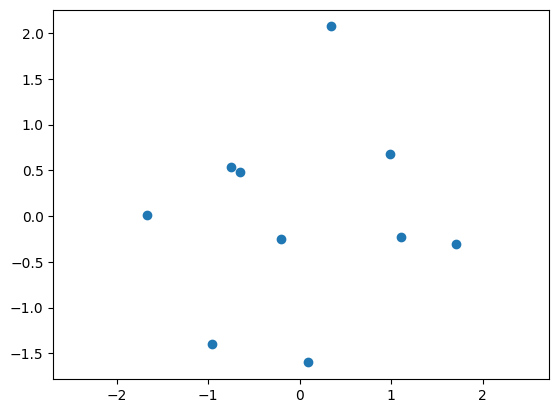

In [7]:
n_components = 2
X = np.random.randn(10,10)
std = StandardScaler()
X = std.fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

fit time CPU :    0.019960880279541016
eigenvalues :    [5.59964217 4.39078833]
original shape:    (10, 10)
transformed shape: (10, 2)


(-2.8806758630873883, 3.915051123344403, -2.038481081264603, 2.662277758201543)

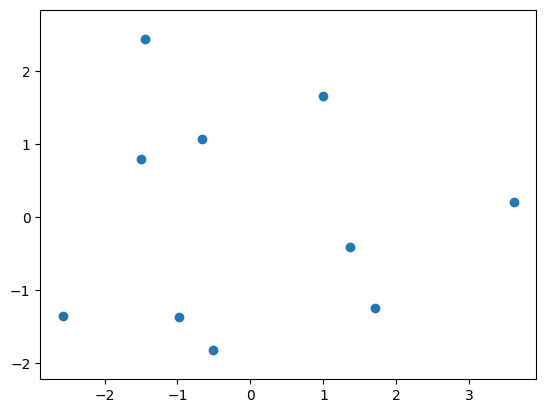

In [8]:
# Initialize PCA with SVD on CPU
pca = PCA(n_components=2)
t1 = time()
pca.fit(X)
t2 = time()
print("fit time CPU :   ", t2 - t1)
X_pca = pca.transform(X)
print("eigenvalues :   ", pca.singular_values_)
#print("X_pca :   \n", X_pca, "\n")

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.axis('equal')

# Implementation of NIPALS PCA on GPU

In this first version, we kept the functions from original github, while adapting the code to work on our data.

We compared the eigenvalues of CPU and GPU PCA.

In [4]:
# Multiply X.T * th
def multiply_transpose(X_gpu, T_gpu, P_gpu, M, N):
    mult_transpose = SourceModule("""
            # define M %(size_M)d
            # define N %(size_N)d
            __global__ void mult_transpose(float *X, float *T ,  float *P)
            {
            // Block row and column
            int row = blockIdx.x*blockDim.x + threadIdx.x;
            float sum = 0;
            for (int m= 0; m < M; ++m)
            {   
                sum += X[row + m*N]*T[m];     
            }
            // Write the value to the subvector Tsub
            P[row] = sum;
            }
             """ % {"size_M": M, "size_N": N})

    mult_transpose_gpu = mult_transpose.get_function("mult_transpose")

    block_size = (min(N, 1024), 1, 1)
    grid_size = (int(np.ceil(N / block_size[0])), 1, 1)
    mult_transpose_gpu(X_gpu, T_gpu, P_gpu,
                       block=block_size, grid=grid_size)

    return P_gpu

# Return norme squared sum(a*a)


def Norme2(a_gpu, b_gpu, c_gpu, N):
    # THREADS_PER_BLOCK = 1024 
    kernel_code_template = """
            __global__ void dot(float *a, float *b,float *c) {
          __shared__ float temp[1024];
          int index = threadIdx.x + blockIdx.x  *blockDim.x;
          temp[threadIdx.x] = a[index] * b[index];
            __shared__ float cache;
          if (threadIdx.x == 0) {
            if ((blockIdx.x + 1) * 1024<= %(N)s)
              cache = 1024;
            else cache = fmodf(%(N)s, 1024);
          }
          __syncthreads();
          if (threadIdx.x == 0) {
              float sum =0;
              for (int i =0; i< cache; i++) {
                  sum += temp[i];
                  }
              atomicAdd(c, sum);
              }
              
          }
         """

    kernel_code = kernel_code_template % {
        'N': N,
    }
    mod = SourceModule(kernel_code)

    func = mod.get_function("dot")

    blocksPerGrid = (int((N + 1024-1)/1024), 1)

    func(a_gpu, a_gpu, c_gpu, block=(1024, 1, 1), grid=blocksPerGrid)

    return c_gpu.get()

# Normalize P/ ||P||


def normalize_vector(P_gpu, N):
    normalize = SourceModule("""
        # include <math.h>
        __global__ void normalize(float *P, float norm2_P){
        int idx =  blockIdx.x*blockDim.x + threadIdx.x;
        P[idx]=P[idx]/norm2_P;
        }
        """)
    normalize_gpu = normalize.get_function("normalize")
    num_threads = int(np.ceil(N))
    grid_size = int(np.ceil(num_threads / 1024))
    out = np.zeros(1, dtype=np.float32)
    out_gpu = gpuarray.to_gpu(out)
    sum_P = Norme2(P_gpu, P_gpu, out_gpu, N)
    norm2_P = np.float32(np.sqrt(sum_P))
    if grid_size > 1:
        block_size = 1024
    else:
        block_size = num_threads
    normalize_gpu(P_gpu, norm2_P, block=(
        block_size, 1, 1), grid=(grid_size, 1, 1))

    return P_gpu

# Multiply X * P


def multipy(X_gpu, P_gpu, T_gpu, M, N):
    mult = SourceModule("""
        # include <math.h>
        # define N %(size)d
        __global__ void mult(float *X, float *P, float *T)
        {
        // Block row and column
        int row = blockIdx.x*blockDim.x + threadIdx.x;
        float sum = 0;
        for (int n = 0; n < N; ++n)
        {
            sum += X[row*N + n]*P[n];
        }
        // Write the value to the subvector Tsub
        T[row] = sum;
    }
    """ % {"size": N})
    mult_gpu = mult.get_function("mult")
    block_size = (min(M, 1024), 1, 1)
    grid_size = (int(np.ceil(M / block_size[0])), 1, 1)
    mult_gpu(X_gpu, P_gpu, T_gpu, block=block_size, grid=grid_size)

    return T_gpu


# Multiply X - T @ P.T  ( Mx1 * 1xN)
def update(X_gpu, T_gpu, P_gpu, M, N, scalar):
    outer_mult = SourceModule("""
        # include <stdio.h>
        # define M %(size_M)d
        # define N %(size_N)d
        __global__ void outer_mult(float *X, float *T ,  float *P,float scalar )
        {
        int bx = blockIdx.x;
        int by = blockIdx.y;
        int tx = threadIdx.x;
        int ty = threadIdx.y;
        // Block row and column
        int row = by*blockDim.y + ty;
        int col = bx*blockDim.x + tx;
        //int dim = gridDim.x*blockDim.x;
        if (row < M && col < N){
            int idx = row*N + col ;
            X[idx] -= scalar*T[row]*P[col];
        }
        }
        """ % {"size_M": M, "size_N": N})
    outer = outer_mult.get_function("outer_mult")
    block_size = (min(N, 32), min(M, 32), 1)
    grid_size = (
        int(np.ceil(N / block_size[0])), int(np.ceil(M / block_size[1])), 1)
    outer(X_gpu, T_gpu, P_gpu, np.float32(
        scalar), block=block_size, grid=grid_size)
    return X_gpu

# Use sqrt(norm2)


def substract(out_gpu, T_gpu, P_gpu, N):
    sub = SourceModule("""
        # include <stdio.h>
        # define N %(size_N)d
        __global__ void sub(float *X, float *T ,  float *P,float scalar )
        {
        int row = blockIdx.x*blockDim.x + threadIdx.x;
        if(row < N){
            X[row] = T[row] - P[row];
        }
        }
        """ % {"size_N": N})
    sub_func = sub.get_function("sub")
    block_size = (min(N, 32), 1, 1)
    grid_size = (
        int(np.ceil(N / block_size[0])), 1, 1)

    sub_func(out_gpu, T_gpu, P_gpu, block=block_size, grid=grid_size)
    return out_gpu


def get_eigenvalue(T_gpu, M):
    out = np.zeros(1, dtype=np.float32)
    out_gpu = gpuarray.to_gpu(out)
    sum_T = Norme2(T_gpu, T_gpu, out_gpu, M)
    norm2_T = np.sqrt(sum_T)
    return norm2_T

In [5]:
class Nipals_GPU():
    def __init__(self, ncomp=None, tol=1e-5, maxiter=100):
        self.tol = tol
        self.maxiter = maxiter
        self.ncomp = ncomp

    def onestepcomp_gpu(self, X_gpu, comp):
        # get comp row
        th = self.X_PCA[:, comp]
        ph = np.zeros((self.N,)).astype(np.float32)

        # th = self.X_GPU[:, comp]
        # NOTE : +20s  on test don't get why

        th_gpu = gpuarray.to_gpu(th)
        ph_gpu = gpuarray.to_gpu(ph)
        eig = 0

        for j in range(self.maxiter):
            # Normalize X.T*th
            multiply_transpose(X_gpu, th_gpu, ph_gpu, self.M, self.N)

            # Normalize ph/ ||ph||
            normalize_vector(ph_gpu, self.N)

            # Multiply X * ph
            multipy(X_gpu, ph_gpu, th_gpu, self.M, self.N)

            # Compute eigenvalue
            eigh = get_eigenvalue(th_gpu,self.M)
            
            # Condition to stop iterating if convergence is observed
            if(np.abs(eigh - eig) < self.tol):
                break
            eig = eigh
        return th_gpu, ph_gpu, eigh

    def fit_on_GPU(self, X):
        """
        fit method
        -------
        parametres : X data N x N Matrix 
        output : True       
        ------
        """
        self.X = X.astype(np.float32)

        # move to GPU
        self.X_PCA = self.X
        self.X_GPU = gpuarray.to_gpu(self.X_PCA)

        # should correspond to X.T.shape
        self.M, self.N = self.X_GPU.shape

        if self.ncomp is None:
            ncomp = min(self.X.shape)
        else:
            try:
                assert self.ncomp <= min(
                    self.M, self.N), "can't have this value will set ncomp to{}".format(min(X.shape))
                ncomp = self.ncomp
            except AssertionError as msg:
                print(msg)
                ncomp = min(self.X.shape)

        eig = np.empty((ncomp,)).astype(np.float32)
        loadings = np.empty((self.N, ncomp)).astype(np.float32)
        scores = np.empty((self.M, ncomp)).astype(np.float32)

        # initialize outputs on gpu
        self.loadings_gpu = gpuarray.to_gpu(loadings)
        self.scores_gpu = gpuarray.to_gpu(scores)

        for comp in range(ncomp):
            # Calculate on full matrix
            th_gpu, ph_gpu, eigh = self.onestepcomp_gpu(self.X_GPU, comp)

            # Update X
            self.X_GPU = update(self.X_GPU, th_gpu, ph_gpu,self.M,self.N,1)
            self.loadings_gpu[:, comp] = ph_gpu.get()
            self.scores_gpu[:, comp] = th_gpu.get()
            eig[comp] = eigh

        # Get results
        self.eig = eig
        self.scores = scores
        self.loadings = loadings

        #return "Done"

    def transform(self):
        """
        transform method
        -------
        output : PCA data 
        ------
        """
        print('eigenvalues :', self.eig)
        X_centered = self.X - np.mean(self.X, axis=0)
        X_pca = np.dot(X_centered, self.loadings)

        return X_pca

fit time GPU :    1.9953830242156982
eigenvalues : [5.5996385 4.3907776]
original shape:    (10, 10)
transformed shape: (10, 2)


(-11.486788082122803, 11.740534114837647, -8.78788139820099, 8.571473145484925)

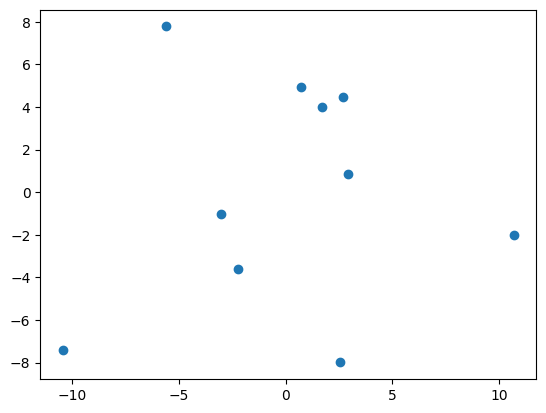

In [9]:
pca_nipals = Nipals_GPU(ncomp=2)
t1 = time()
pca_nipals.fit_on_GPU(X)
t2 = time()
print("fit time GPU :   ", t2 - t1)
X_pca = pca_nipals.transform()
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.axis('equal')

# Optimized version on GPU
The previous algorithm is accuretly running on GPU, performing PCA via NIPALS algorithm. But some instructions parasitize the code by slowing it down, forcing more CPU -> GPU or GPU -> CPU transfers than necessary. 

In this part we try to change the code to accelerate the computation time on GPU :     

- we remove all the prints in functions
- we remove the calculation of eigenvalues that we added to compare the NIPALS performances with pca from sklearn.
- we build a function to draw a chart like the one in the studied paper, comparing performances of both CPU and GPU implementations according to the size of input matrix X.

In [11]:
from time import time

class Nipals_GPU_v2():
    def __init__(self, ncomp=None, tol=1e-5, maxiter=100):
        self.tol = tol
        self.maxiter = maxiter
        self.ncomp = ncomp

    def onestepcomp_gpu(self, X_gpu, comp):
        # get comp row
        T = self.X_PCA[:, comp]
        P = np.zeros((self.N,)).astype(np.float32)

        T_gpu = gpuarray.to_gpu(T)
        P_gpu = gpuarray.to_gpu(P)
        eig = 0

        for j in range(self.maxiter):
            # Normalize X.T*T
            multiply_transpose(X_gpu, T_gpu, P_gpu, self.M, self.N)

            # Normalize P/ ||P||
            normalize_vector(P_gpu, self.N)

            # Multiply X * P
            multipy(X_gpu, P_gpu, T_gpu, self.M, self.N)

            # Compute eigenvalue
            # eigh = get_eigenvalue(T_gpu,self.M)
            # print('Time for multipy eigenvalue', t2-t1)
            
            # Condition to stop iterating if convergence is observed
            # if(np.abs(eigh - eig) < self.tol):
            #     break
            # eig = eigh
        return T_gpu, P_gpu #, eigh

    def fit_on_GPU(self, X):
        """
        fit meTod
        -------
        parametres : X data N x N Matrix 
        output : True       
        ------
        """
        self.X = X.astype(np.float32)

        # move to GPU
        self.X_PCA = self.X
        self.X_GPU = gpuarray.to_gpu(self.X_PCA)

        # should correspond to X.T.shape
        self.M, self.N = self.X_GPU.shape

        if self.ncomp is None:
            ncomp = min(self.X.shape)
        else:
            try:
                assert self.ncomp <= min(
                    self.M, self.N), "can't have Tis value will set ncomp to{}".format(min(X.shape))
                ncomp = self.ncomp
            except AssertionError as msg:
                print(msg)
                ncomp = min(self.X.shape)

        #eig = np.empty((ncomp,)).astype(np.float32)
        loadings = np.empty((self.N, ncomp)).astype(np.float32)
        scores = np.empty((self.M, ncomp)).astype(np.float32)

        # initialize outputs on gpu
        self.loadings_gpu = gpuarray.to_gpu(loadings)
        self.scores_gpu = gpuarray.to_gpu(scores)

        for comp in range(ncomp):
            # Calculate on full matrix
            #T_gpu, P_gpu, eigh = self.onestepcomp_gpu(self.X_GPU, comp)
            T_gpu, P_gpu = self.onestepcomp_gpu(self.X_GPU, comp)

            # Update X
            self.X_GPU = update(self.X_GPU, T_gpu, P_gpu,self.M,self.N,1)
            self.loadings_gpu[:, comp] = P_gpu.get()
            self.scores_gpu[:, comp] = T_gpu.get()
            #eig[comp] = eigh

        # Get results
        #self.eig = eig
        self.scores = scores
        self.loadings = loadings


    def transform(self):
        """
        transform method
        -------
        output : PCA data 
        ------
        """
        #print('eig :', self.eig)
        X_centered = self.X - np.mean(self.X, axis=0)
        X_pca = np.dot(X_centered, self.loadings)

        return X_pca

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


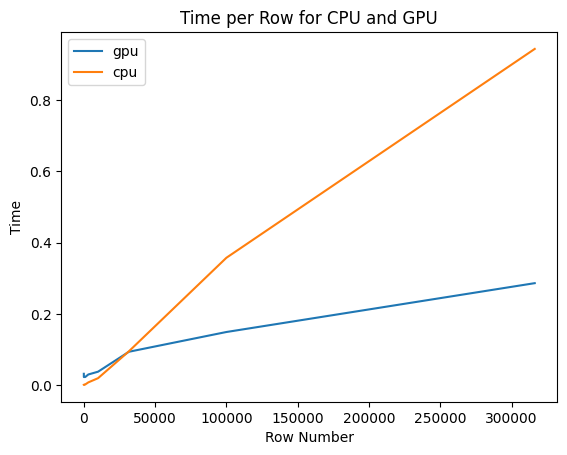

In [ ]:
#@title Comparison of computation time between sklearn method and out gpu implementation with increasing number of rows
relative_time = {"gpu":[], "cpu":[]}
rows = [10**n for n in np.arange(1, 6, 0.5)]
for row in rows:
    n_components = 2
    # Initialize X
    X = np.random.randn(int(row),10)
    std = StandardScaler()
    X = std.fit_transform(X)
    # GPU PCA
    pca_gpu = Nipals_GPU_v2(ncomp=2)
    t1 = time()
    pca_gpu.fit_on_GPU(X)
    t2 = time()
    relative_time["gpu"].append(t2 - t1)
    # CPU PCA
    pca_cpu = PCA(n_components=2)
    t1 = time()
    pca_cpu.fit(X)
    t2 = time()
    relative_time["cpu"].append(t2 - t1)
# plot the curves for each device
for device in relative_time:
    times = relative_time[device]
    plt.plot(rows, times, label=device)

# add legend, title, and axis labels
plt.legend()
plt.title("Time per Row for CPU and GPU")
plt.xlabel("Row Number")
plt.ylabel("Time")

# display the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_

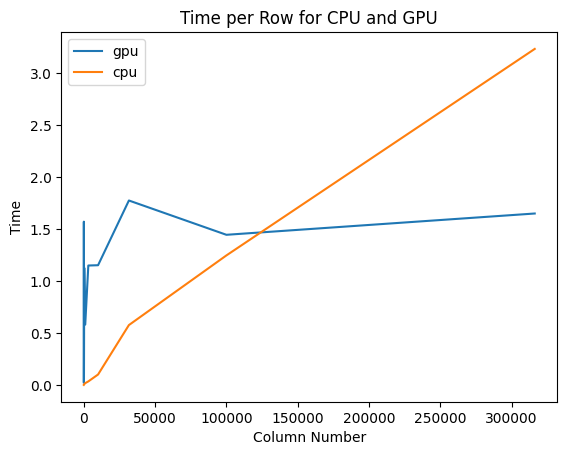

In [ ]:
#@title Comparison of computation time between sklearn method and our gpu implementation with increasing number of columns
relative_time = {"gpu":[], "cpu":[]}
rows = [10**n for n in np.arange(1, 6, 0.5)]
for row in rows:
    n_components = 2
    # Initialize X
    X = np.random.randn(100,int(row))
    std = StandardScaler()
    X = std.fit_transform(X)
    # GPU PCA
    pca_gpu = Nipals_GPU_v2(ncomp=2)
    t1 = time()
    pca_gpu.fit_on_GPU(X)
    t2 = time()
    relative_time["gpu"].append(t2 - t1)
    # CPU PCA
    pca_cpu = PCA(n_components=2)
    t1 = time()
    pca_cpu.fit(X)
    t2 = time()
    relative_time["cpu"].append(t2 - t1)
# plot the curves for each device
for device in relative_time:
    times = relative_time[device]
    plt.plot(rows, times, label=device)

# add legend, title, and axis labels
plt.legend()
plt.title("Time per Column for CPU and GPU")
plt.xlabel("Column Number")
plt.ylabel("Time")

# display the plot
plt.show()


# Comparison between two implementations of same iterative NIPALS-PCA, one on CPU and one on GPU

As specified in the paper, the SVD method used in sklearn, while optimized, is sub-optimal compared to iterative NIPALS. We tried to implement a CPU version of NIPALS, based on pseud-code given in the article.

The results does not show a significant improvement of using GPU implementation, bu it seems that the slope of CPU computation time is higher than the one for GPU computation time, and so that it could be significantly better with matrix of higher size. Unfortunately, due to limited capacity of Colab GPU, we couldn't test it.

In [19]:
#@title Custom implementation of NIPALS on CPU

def Nipals_CPU(X, n_components=2, max_iter=100, epsilon=1e-5):
    """
    Computes the leading K eigenvectors and eigenvalues of matrix X using the power iteration method
    Returns the eigenvectors T, the eigenvalues P, and the residual matrix R
    """
    R = X.copy()  # initialize R to be X
    T = np.zeros((X.shape[0], n_components))  # initialize T to be zeros
    P = np.zeros(n_components)  # initialize P to be zeros
    for k in range(n_components):
        lamda = 0
        Tk = R[:, k]  # initialize Tk to be the k-th column of R
        for j in range(max_iter):
            Pk = R.T @ Tk  # compute the power iteration vector Pk
            Pk_norm = np.linalg.norm(Pk)  # compute the norm of Pk
            Pk = Pk / Pk_norm  # normalize Pk
            Tk = R @ Pk  # compute the next power iteration vector Tk
            lamda_new = Tk[k]  # compute the new eigenvalue estimate
            if abs(lamda_new - lamda) <= epsilon:  # check for convergence
                break
            lamda = lamda_new  # update the eigenvalue estimate
        T[:, k] = Tk  # store the k-th eigenvector in T
        P[k] = lamda  # store the k-th eigenvalue in P
        R = R - np.outer(Tk, Pk)  # subtract the contribution of the k-th eigenvector/eigenvalue from R
    return T, P, R

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: module in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: U

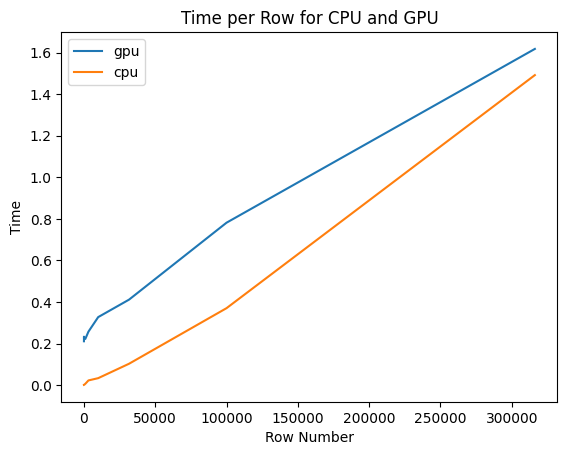

In [22]:
#@title Comparison of computation time between implemented NIPALS method and our gpu implementation with increasing number of rows
relative_time = {"gpu":[], "cpu":[]}
rows = [10**n for n in np.arange(1, 6, 0.5)]
for row in rows:
    n_components = 2
    # Initialize X
    X = np.random.randn(int(row),10)
    std = StandardScaler()
    X = std.fit_transform(X)
    # GPU PCA
    pca_gpu = Nipals_GPU_v2(ncomp=2)
    t1 = time()
    pca_gpu.fit_on_GPU(X)
    t2 = time()
    relative_time["gpu"].append(t2 - t1)
    # CPU PCA
    t1 = time()
    Nipals_CPU(X)
    t2 = time()
    relative_time["cpu"].append(t2 - t1)
# plot the curves for each device
for device in relative_time:
    times = relative_time[device]
    plt.plot(rows, times, label=device)

# add legend, title, and axis labels
plt.legend()
plt.title("Time per Row for CPU and GPU")
plt.xlabel("Row Number")
plt.ylabel("Time")

# display the plot
plt.show()
